# Required Packages

Ensure you have the following Python packages installed to run this notebook:

- `numpy`: For numerical operations.
- `qrcode`: To generate QR codes.
- `Pillow`: For image processing.
- `pyzbar`: To decode QR codes from images.
- `matplotlib` or `IPython.display`: For displaying images within the notebook.
- `gurobipy`: The Python API for Gurobi optimizer.

You can install these packages via pip and system commands if you don't have them already:

```bash
pip install numpy qrcode[pil] matplotlib Pillow pyzbar
sudo apt-get install libzbar0


In [ ]:
#!pip install gurobipy  # install gurobipy, if not already installed

In [ ]:
#!pip install Pillow pyzbar
#!apt-get install libzbar0

In [ ]:
#!pip install qrcode[pil]

In [ ]:
import numpy as np
import gurobipy as gp
import itertools
import random
import string
import time
import os

**Read input matrix(image)**

In [ ]:
def read_data(file_name):
    # Read data from file and store in a matrix, and manage M, N, and mapping
    matrix = np.loadtxt(file_name)
    M, N = matrix.shape

    mapping = {}
    _edge_idx = 0

    # Generate keys for subsets of a 2x2 block of size 2, 3, and 4
    for i in range(M - 1):
        for j in range(N - 1):
            arr = [(i, j), (i, j + 1), (i + 1, j), (i + 1, j + 1)]
            # Generate combinations of size 2, 3, and 4
            for size in range(2, 5):  # Only combinations of size 2, 3, and 4
                for subset in itertools.combinations(arr, size):
                    key = ','.join(f"{pair[0]},{pair[1]}" for pair in subset) + ','
                    if key not in mapping:
                        mapping[key] = _edge_idx
                        _edge_idx += 1

    return matrix, mapping

#clean_matrix, mapping = read_data('/content/random_qr_matrix3.txt')

**Generate QR codes containing random strings**

In [ ]:
import qrcode

def generate_random_string(length=10):
    #Generate a random string of fixed length
    letters = string.ascii_letters + string.digits
    random_string = ''.join(random.choice(letters) for i in range(length))
    return random_string

def create_qr_code(data, file_path, imsize):
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=1,
        border=0
    )
    qr.add_data(data)
    qr.make(fit=True)

    img = qr.make_image(fill_color="black", back_color="white")
    img = img.resize((imsize, imsize))
    img.save(file_path)

    # Convert image to binary matrix
    return np.array(img.convert('L')) > 128  # Threshold grayscale to binary

# example usage
random_data = generate_random_string(30)
binary_matrix = create_qr_code(random_data, 'test.png', 5)
np.savetxt('test.txt', binary_matrix.astype(int), fmt='%d', delimiter=' ')
print(f"Generated QR code for data: {random_data}")

Generated QR code for data: kIl0OWyNQXySDrVOGWvje28lmbmoLO


**Convert matrix back to image**

In [ ]:
from PIL import Image

def matrix_to_qr_code(matrix, file_path, imsize):
    binary_image = matrix.astype(bool)

    img = Image.fromarray(np.uint8(binary_image * 255), 'L')

    img = img.resize((imsize, imsize), Image.NEAREST)

    img.save(file_path)

    img.show()

# Example usage
matrix_to_qr_code(binary_matrix, 'test.png', 100)

In [ ]:
from PIL import Image
from pyzbar.pyzbar import decode

def can_scan_qr(X):
    # Convert the 0-1 matrix to a binary image format (255 for 1, 0 for 0)
    image = Image.fromarray(np.uint8(X * 255), 'L')

    # Attempt to decode the QR code
    result = decode(image)

    # Return True if decoding is successful, False otherwise
    return len(result) > 0

**Learning potential value from training set**

for each $2 \times 2$ patch, we charactrized different configurations into **4** groups

In [4]:
def learn_potential(directory):
    total_potential = [0.0] * 4
    total_matrices = 0

    files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    total_matrices = len(files)

    for file_name in files:
        matrix = np.loadtxt(file_name)

        potential = [0] * 4

        M, N = matrix.shape

        num_areas = (M - 1) * (N - 1)

        for i in range(M - 1):
            for j in range(N - 1):
                submatrix = [matrix[i][j], matrix[i][j + 1], matrix[i + 1][j], matrix[i + 1][j + 1]]
                if submatrix == [0, 0, 0, 0] or submatrix == [1, 1, 1, 1]:
                    potential[0] += 1
                elif submatrix in ([0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 1, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]):
                    potential[1] += 1
                elif submatrix in ([0, 0, 1, 1], [1, 1, 0, 0], [0, 1, 0, 1], [1, 0, 1, 0]):
                    potential[2] += 1
                elif submatrix in ([1, 0, 0, 1], [0, 1, 1, 0]):
                    potential[3] += 1

        # Calculate pattern potentials as proportions
        pattern_potential = [x / num_areas for x in potential]

        total_potential = [x + y for x, y in zip(total_potential, pattern_potential)]

    average_potential = [x / total_matrices for x in total_potential]

    # Calculate objective coefficients
    objective_coefficients = [0.0] * 15
    temp = [
        pattern_potential[1] - pattern_potential[0],  # xi
        pattern_potential[0] - 2 * pattern_potential[1] + pattern_potential[2],  # xixj
        -pattern_potential[0] + 4 * pattern_potential[1] - 2 * pattern_potential[2] - pattern_potential[3],  # xixjxk
        2 * pattern_potential[0] - 8 * pattern_potential[1] + 4 * pattern_potential[2] + 2 * pattern_potential[3],  # term 4
        pattern_potential[0] - 2 * pattern_potential[1] + pattern_potential[3]  # xixj alternative
    ]

    for i in range(4):
        objective_coefficients[i] = temp[0]
    for i in range(4, 6):
        objective_coefficients[i] = temp[4]
    for i in range(6, 10):
        objective_coefficients[i] = temp[1]
    for i in range(10, 14):
        objective_coefficients[i] = temp[2]
    objective_coefficients[14] = temp[3]

    return average_potential, objective_coefficients

# Example usage:
average_potential, objective_coefficients = learn_potential('train_set')
print(average_potential)
print(objective_coefficients)

[0.6174927113702624, 0.06638900458142441, 0.30412328196584754, 0.011995002082465641]
[-0.5481049562682216, -0.5481049562682216, -0.5481049562682216, -0.5481049562682216, 0.49645980841316123, 0.49645980841316123, 0.791753436068305, 0.791753436068305, 0.791753436068305, 0.791753436068305, -0.9837567680133278, -0.9837567680133278, -0.9837567680133278, -0.9837567680133278, 1.9675135360266556]


**Using Gurobi as IP and LP solver**



In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

env = gp.Env(params=params)

def e(mapping, *args):
    """ Helper function to convert indices into mapping keys. """
    filtered_indices = [arg for arg in args if arg != (-1, -1)]
    filtered_indices.sort(key=lambda x: (x[0], x[1]))
    key = ','.join(f"{idx[0]},{idx[1]}" for idx in filtered_indices) + ','
    if key not in mapping:
        print("Key Error:", key)
        print("Available keys:", mapping.keys())
    return mapping.get(key, 'Default')


def define_model(matrix, mapping):
    M, N = matrix.shape
    model = gp.Model(env=env)

    x = [[model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}") for j in range(N)] for i in range(M)]
    y = [model.addVar(vtype=GRB.BINARY, name=f"y_{i}") for i in range(len(mapping))]

    # Using clique LP as constraints
    for i in range(M - 1):
      for j in range(N - 1):
          v1, v2, v3, v4 = (i, j), (i, j + 1), (i + 1, j), (i + 1, j + 1)

          y_v1_v2_v3 = y[e(mapping, v1, v2, v3)]
          y_v1_v2_v4 = y[e(mapping, v1, v2, v4)]
          y_v1_v3_v4 = y[e(mapping, v1, v3, v4)]
          y_v2_v3_v4 = y[e(mapping, v2, v3, v4)]
          y_v1_v2_v3_v4 = y[e(mapping, v1, v2, v3, v4)]
          y_v1_v2 = y[e(mapping, v1, v2)]
          y_v1_v3 = y[e(mapping, v1, v3)]
          y_v1_v4 = y[e(mapping, v1, v4)]
          y_v2_v3 = y[e(mapping, v2, v3)]
          y_v2_v4 = y[e(mapping, v2, v4)]
          y_v3_v4 = y[e(mapping, v3, v4)]
          model.addConstr(y_v1_v2_v3 - y_v1_v2_v3_v4 >= 0)
          model.addConstr(y_v1_v2_v4 - y_v1_v2_v3_v4 >= 0)
          model.addConstr(y_v1_v3_v4 - y_v1_v2_v3_v4 >= 0)
          model.addConstr(y_v2_v3_v4 - y_v1_v2_v3_v4 >= 0)
          model.addConstr(-y_v1_v2 + y_v1_v2_v3 + y_v1_v2_v4 - y_v1_v2_v3_v4 <= 0)
          model.addConstr(-y_v1_v3 + y_v1_v2_v3 + y_v1_v3_v4 - y_v1_v2_v3_v4 <= 0)
          model.addConstr(-y_v1_v4 + y_v1_v2_v4 + y_v1_v3_v4 - y_v1_v2_v3_v4 <= 0)
          model.addConstr(-y_v2_v3 + y_v1_v2_v3 + y_v2_v3_v4 - y_v1_v2_v3_v4 <= 0)
          model.addConstr(-y_v2_v4 + y_v1_v2_v4 + y_v2_v3_v4 - y_v1_v2_v3_v4 <= 0)
          model.addConstr(-y_v3_v4 + y_v1_v3_v4 + y_v2_v3_v4 - y_v1_v2_v3_v4 <= 0)
          model.addConstr(-x[i][j] + y_v1_v2 + y_v1_v3 + y_v1_v4 - y_v1_v2_v3 - y_v1_v2_v4 - y_v1_v3_v4 + y_v1_v2_v3_v4 <= 0)
          model.addConstr(-x[i][j+1] + y_v1_v2 + y_v2_v3 + y_v2_v4 - y_v1_v2_v3 - y_v1_v2_v4 - y_v2_v3_v4 + y_v1_v2_v3_v4 <= 0)
          model.addConstr(-x[i+1][j] + y_v1_v3 + y_v2_v3 + y_v3_v4 - y_v1_v2_v3 - y_v1_v3_v4 - y_v2_v3_v4 + y_v1_v2_v3_v4 <= 0)
          model.addConstr(-x[i+1][j+1] + y_v1_v4 + y_v2_v4 + y_v3_v4 - y_v1_v2_v4 - y_v1_v3_v4 - y_v2_v3_v4 + y_v1_v2_v3_v4 <= 0)
          model.addConstr(x[i][j] + x[i][j+1] + x[i+1][j] + x[i+1][j+1] - y_v1_v2 - y_v1_v3 - y_v1_v4 - y_v2_v3 - y_v2_v4 - y_v3_v4 + y_v1_v2_v3 + y_v1_v2_v4 + y_v1_v3_v4 + y_v2_v3_v4 - y_v1_v2_v3_v4 <= 1)
    return model,x,y

def optimizer(model, x, y, obj_coe, weight, perturbated_matrix, matrix, mapping):

    M, N = matrix.shape
    obj = gp.LinExpr()
    for i in range(M):
        for j in range(N):
            if perturbated_matrix[i][j] == 0:
                obj += (-weight) * x[i][j]
            else:
                obj += weight * x[i][j]

    for i in range(M - 1):
        for j in range(N - 1):
            v1 = (i, j)
            v2 = (i, j + 1)
            v3 = (i + 1, j)
            v4 = (i + 1, j + 1)

            obj += obj_coe[0] * x[i][j]
            obj += obj_coe[1] * x[i][j + 1]
            obj += obj_coe[2] * x[i + 1][j]
            obj += obj_coe[3] * x[i + 1][j + 1]

            obj += obj_coe[4] * y[e(mapping, v1, v4)]
            obj += obj_coe[5] * y[e(mapping, v2, v3)]
            obj += obj_coe[6] * y[e(mapping, v1, v2)]
            obj += obj_coe[7] * y[e(mapping, v2, v4)]
            obj += obj_coe[8] * y[e(mapping, v3, v4)]
            obj += obj_coe[9] * y[e(mapping, v1, v3)]
            obj += obj_coe[10] * y[e(mapping, v1, v2, v3)]
            obj += obj_coe[11] * y[e(mapping, v1, v2, v4)]
            obj += obj_coe[12] * y[e(mapping, v1, v3, v4)]
            obj += obj_coe[13] * y[e(mapping, v2, v3, v4)]
            obj += obj_coe[14] * y[e(mapping, v1, v2, v3, v4)]

    model.setObjective(obj, GRB.MAXIMIZE)
    # model.setParam('OutputFlag', 0)
    # Optimize the model
    model.optimize()

    # Extract and return solution details
    is_binary = all(x[i][j].X in [0, 1] for i in range(M) for j in range(N))
    recovery_rate = sum(1 for i in range(M) for j in range(N) if abs(x[i][j].X - matrix[i][j]) < 1e-3) / (M * N)
    res_matrix = np.zeros((M, N))
    for i in range(M):
      for j in range(N):
        res_matrix[i, j] = x[i][j].X
    is_scanned = can_scan_qr(res_matrix)

    return {
        "is_binary": is_binary,
        "is_scanned": is_scanned,
        "objective_value": model.objVal if model.status == GRB.OPTIMAL else None,
        "recovery_rate": recovery_rate
    }, res_matrix

# Example usage
matrix, mapping = read_data('test.txt')

M, N = matrix.shape
noisy_matrix = np.copy(matrix)
for i in range(M):
    for j in range(N):

        if np.random.rand() < 0.3:

            noisy_matrix[i, j] = 1 - noisy_matrix[i, j]

model,x,y = define_model(matrix,mapping)
weight = 1.0
average_potential, obj_coe = learn_potential('train_set')
print(M,N)
print(average_potential)
print(optimizer(model,x,y,obj_coe, weight, noisy_matrix, matrix, mapping))


**Using naive grid search to decide weight**

In [ ]:
def grid_search(train_set):
      files_dir = [os.path.join(train_set, f) for f in os.listdir(train_set) if os.path.isfile(os.path.join(train_set, f))]
      total_matrices = len(files_dir)

      # matrix, mapping = read_data('/content/random_qr_matrix1.txt')

      # model,x,y = define_model(matrix,mapping)

      average_potential, obj_coe = learn_potential(train_set)
      print(average_potential)

      results = {}
      weight_levels = [round(x, 1) for x in np.arange(0.1, 1.6, 0.1)]  # Generate 15 evenly spaced weight levels from 0.1 to 1.5
      all_files_matrix = np.zeros((len(weight_levels), len([ 0.1,  0.2,  0.3])))

      # Iterate over each file in the directory
      for file_name in files_dir:
          print(f"Processing file: {file_name}")
          matrix, mapping = read_data(file_name)
          model,x,y = define_model(matrix,mapping)
          M, N = matrix.shape
          file_results = {}
          for noise_idx, noise_level in enumerate([ 0.1,  0.2,  0.3]):
              print(f"  Noise level: {noise_level}")
              noise_results = {}
              for weight_idx, weight_level in enumerate(weight_levels):
                  print(f"    Weight level: {weight_level}")
                  total_recovery_rate = 0
                  for trial in range(50):
                      # Perturb the matrix once per trial
                      noisy_matrix = np.copy(matrix)
                      for i in range(M):
                          for j in range(N):
                              if np.random.rand() < noise_level:
                                  noisy_matrix[i, j] = 1 - noisy_matrix[i, j]
                      # Run the optimizer for each weight level on the same perturbed matrix of the trial
                      res, redundant_matrix = optimizer(model, x, y, obj_coe, weight_level, noisy_matrix, matrix, mapping)

                      # Print the noise level, weight level, trial number, recovery rate, and solving time
                      print(f"      Trial: {trial+1}/{50}, Recovery Rate: {res['recovery_rate']}, Solving Time: {model.Runtime} seconds")

                      # Accumulate the recovery rate for the current weight level
                      total_recovery_rate += res["recovery_rate"]
                  # Calculate the average recovery rate for the current weight level
                  avg_recovery_rate = total_recovery_rate / 50
                  noise_results[weight_level] = avg_recovery_rate
                  print(f"    Average recovery rate for weight level {weight_level}: {avg_recovery_rate}")

                  # Update the all_files_matrix with the average recovery rate for the current weight and noise pair
                  all_files_matrix[weight_idx, noise_idx] += avg_recovery_rate

              file_results[noise_level] = noise_results

          results[file_name] = file_results
          print(f"File {file_name} processed.")

      # Calculate the average recovery rate over all files for each weight and noise pair
      all_files_matrix /= len(files_dir)
      print("All files processed.")

      return results, all_files_matrix


results, all_files_matrix = grid_search('train_set')


**LP relaxations**

Define LP relaxations and inference testing set

In [ ]:
def define_LP(matrix, mapping, LPversion):
    M, N = matrix.shape
    model = gp.Model(env=env)

    x = [[model.addVar(vtype=GRB.CONTINUOUS, lb = 0.0, ub = 1.0, name=f"x_{i}_{j}") for j in range(N)] for i in range(M)]
    y = [model.addVar(vtype=GRB.CONTINUOUS, lb = 0.0, ub = 1.0, name=f"y_{i}") for i in range(len(mapping))]

    for i in range(M - 1):
      for j in range(N - 1):
          v1, v2, v3, v4 = (i, j), (i, j + 1), (i + 1, j), (i + 1, j + 1)

          y_v1_v2_v3 = y[e(mapping, v1, v2, v3)]
          y_v1_v2_v4 = y[e(mapping, v1, v2, v4)]
          y_v1_v3_v4 = y[e(mapping, v1, v3, v4)]
          y_v2_v3_v4 = y[e(mapping, v2, v3, v4)]
          y_v1_v2_v3_v4 = y[e(mapping, v1, v2, v3, v4)]
          y_v1_v2 = y[e(mapping, v1, v2)]
          y_v1_v3 = y[e(mapping, v1, v3)]
          y_v1_v4 = y[e(mapping, v1, v4)]
          y_v2_v3 = y[e(mapping, v2, v3)]
          y_v2_v4 = y[e(mapping, v2, v4)]
          y_v3_v4 = y[e(mapping, v3, v4)]
          if LPversion == "SL" or LPversion == "flower" or LPversion == "run":
            model.addConstr(y_v1_v2 <= x[i][j])
            model.addConstr(y_v1_v2 <= x[i][j + 1])
            model.addConstr(y_v1_v2 >= x[i][j] + x[i][j + 1] - 1)
            model.addConstr(y_v1_v3 <= x[i][j])
            model.addConstr(y_v1_v3 <= x[i + 1][j])
            model.addConstr(y_v1_v3 >= x[i][j] + x[i + 1][j] - 1)
            model.addConstr(y_v1_v4 <= x[i][j])
            model.addConstr(y_v1_v4 <= x[i + 1][j + 1])
            model.addConstr(y_v1_v4 >= x[i][j] + x[i + 1][j + 1] - 1)
            model.addConstr(y_v2_v3 <= x[i][j + 1])
            model.addConstr(y_v2_v3 <= x[i + 1][j])
            model.addConstr(y_v2_v3 >= x[i][j + 1] + x[i + 1][j] - 1)
            model.addConstr(y_v2_v4 <= x[i][j + 1])
            model.addConstr(y_v2_v4 <= x[i + 1][j + 1])
            model.addConstr(y_v2_v4 >= x[i][j + 1] + x[i + 1][j + 1] - 1)
            model.addConstr(y_v3_v4 <= x[i + 1][j])
            model.addConstr(y_v3_v4 <= x[i + 1][j + 1])
            model.addConstr(y_v3_v4 >= x[i + 1][j] + x[i + 1][j + 1] - 1)
            model.addConstr(y_v1_v2_v3 <= x[i][j])
            model.addConstr(y_v1_v2_v3 <= x[i][j + 1])
            model.addConstr(y_v1_v2_v3 <= x[i + 1][j])
            model.addConstr(y_v1_v2_v3 >= x[i][j] + x[i][j + 1] + x[i + 1][j] - 2)
            model.addConstr(y_v1_v2_v4 <= x[i][j])
            model.addConstr(y_v1_v2_v4 <= x[i][j + 1])
            model.addConstr(y_v1_v2_v4 <= x[i + 1][j + 1])
            model.addConstr(y_v1_v2_v4 >= x[i][j] + x[i][j + 1] + x[i + 1][j + 1] - 2)
            model.addConstr(y_v1_v3_v4 <= x[i][j])
            model.addConstr(y_v1_v3_v4 <= x[i + 1][j])
            model.addConstr(y_v1_v3_v4 <= x[i + 1][j + 1])
            model.addConstr(y_v1_v3_v4 >= x[i][j] + x[i + 1][j] + x[i + 1][j + 1] - 2)
            model.addConstr(y_v2_v3_v4 <= x[i][j + 1])
            model.addConstr(y_v2_v3_v4 <= x[i + 1][j])
            model.addConstr(y_v2_v3_v4 <= x[i + 1][j + 1])
            model.addConstr(y_v2_v3_v4 >= x[i][j + 1] + x[i + 1][j] + x[i + 1][j + 1] - 2)
            model.addConstr(y_v1_v2_v3_v4 <= x[i][j])
            model.addConstr(y_v1_v2_v3_v4 <= x[i][j + 1])
            model.addConstr(y_v1_v2_v3_v4 <= x[i + 1][j])
            model.addConstr(y_v1_v2_v3_v4 <= x[i + 1][j + 1])
            model.addConstr(y_v1_v2_v3_v4 >= x[i][j] + x[i][j + 1] + x[i + 1][j] + x[i + 1][j + 1] - 3)
          if LPversion == "flower" or LPversion == "run":
            model.addConstr(y_v1_v2 <= y_v1_v2_v3 - x[i+1][j] + 1)
            model.addConstr(y_v1_v2_v3 <= y_v1_v2)
            model.addConstr(y_v1_v2 <= y_v1_v2_v4 - x[i+1][j+1] + 1)
            model.addConstr(y_v1_v2_v4 <= y_v1_v2)
            model.addConstr(y_v1_v3 <= y_v1_v2_v3 - x[i][j+1] + 1)
            model.addConstr(y_v1_v2_v3 <= y_v1_v3)
            model.addConstr(y_v1_v3 <= y_v1_v3_v4 - x[i+1][j+1] + 1)
            model.addConstr(y_v1_v3_v4 <= y_v1_v3)
            model.addConstr(y_v1_v4 <= y_v1_v2_v4 - x[i][j+1] + 1)
            model.addConstr(y_v1_v2_v4 <= y_v1_v4)
            model.addConstr(y_v1_v4 <= y_v1_v3_v4 - x[i+1][j] + 1)
            model.addConstr(y_v1_v3_v4 <= y_v1_v4)
            model.addConstr(y_v2_v3 <= y_v1_v2_v3 - x[i][j] + 1)
            model.addConstr(y_v1_v2_v3 <= y_v2_v3);
            model.addConstr(y_v2_v3 <= y_v2_v3_v4 - x[i+1][j+1] + 1)
            model.addConstr(y_v2_v3_v4 <= y_v2_v3)
            model.addConstr(y_v2_v4 <= y_v1_v2_v4 - x[i][j] + 1)
            model.addConstr(y_v1_v2_v4 <= y_v2_v4)
            model.addConstr(y_v2_v4 <= y_v2_v3_v4 - x[i+1][j] + 1)
            model.addConstr(y_v2_v3_v4 <= y_v2_v4)
            model.addConstr(y_v3_v4 <= y_v1_v3_v4 - x[i][j] + 1)
            model.addConstr(y_v1_v3_v4 <= y_v3_v4)
            model.addConstr(y_v3_v4 <= y_v2_v3_v4 - x[i][j+1] + 1)
            model.addConstr(y_v2_v3_v4 <= y_v3_v4)

            model.addConstr(y_v1_v2_v3 <= y_v1_v2_v3_v4 - x[i+1][j+1] + 1)
            model.addConstr(y_v1_v2_v3_v4 <= y_v1_v2_v3)
            model.addConstr(y_v1_v2_v4 <= y_v1_v2_v3_v4 - x[i+1][j] + 1)
            model.addConstr(y_v1_v2_v3_v4 <= y_v1_v2_v4)
            model.addConstr(y_v1_v3_v4 <= y_v1_v2_v3_v4 - x[i][j+1] + 1)
            model.addConstr(y_v1_v2_v3_v4 <= y_v1_v3_v4)
            model.addConstr(y_v2_v3_v4 <= y_v1_v2_v3_v4 - x[i][j] + 1)
            model.addConstr(y_v1_v2_v3_v4 <= y_v2_v3_v4)

            model.addConstr(y_v1_v2 + y_v3_v4 - y_v1_v2_v3_v4 <= 1)
            model.addConstr(y_v1_v3 + y_v2_v4 - y_v1_v2_v3_v4 <= 1)
            model.addConstr(y_v1_v4 + y_v2_v3 - y_v1_v2_v3_v4 <= 1)
          if LPversion == "run":
            model.addConstr(-x[i][j] + y_v1_v2 + y_v1_v3 - y_v1_v2_v3 <= 0)
            model.addConstr(-x[i][j+1] + y_v1_v2 + y_v2_v3 - y_v1_v2_v3 <= 0)
            model.addConstr(-x[i+1][j] + y_v1_v3 + y_v2_v3 - y_v1_v2_v3 <= 0)
            model.addConstr(-x[i][j] + y_v1_v2 + y_v1_v4 - y_v1_v2_v4 <= 0)
            model.addConstr(-x[i][j+1] + y_v1_v2 + y_v2_v4 - y_v1_v2_v4 <= 0)
            model.addConstr(-x[i+1][j+1] + y_v1_v4 + y_v2_v4 - y_v1_v2_v4 <= 0)
            model.addConstr(-x[i][j] + y_v1_v3 + y_v1_v4 - y_v1_v3_v4 <= 0)
            model.addConstr(-x[i+1][j] + y_v1_v3 + y_v3_v4 - y_v1_v3_v4 <= 0)
            model.addConstr(-x[i+1][j+1] + y_v1_v4 + y_v3_v4 - y_v1_v3_v4 <= 0)
            model.addConstr(-x[i][j+1] + y_v2_v3 + y_v2_v4 - y_v2_v3_v4 <= 0)
            model.addConstr(-x[i+1][j] + y_v2_v3 + y_v3_v4 - y_v2_v3_v4 <= 0)
            model.addConstr(-x[i+1][j+1] + y_v2_v4 + y_v3_v4 - y_v2_v3_v4 <= 0)

            model.addConstr(-x[i][j] + y_v1_v2_v3 + y_v1_v2_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i][j+1] + y_v1_v2_v3 + y_v1_v2_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i][j] + y_v1_v2_v3 + y_v1_v3_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i+1][j] + y_v1_v2_v3 + y_v1_v3_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i][j+1] + y_v1_v2_v3 + y_v2_v3_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i + 1][j] + y_v1_v2_v3 + y_v2_v3_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i][j] + y_v1_v2_v4 + y_v1_v3_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i + 1][j+1] + y_v1_v2_v4 + y_v1_v3_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i][j+1] + y_v1_v2_v4 + y_v2_v3_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i + 1][j+1] + y_v1_v2_v4 + y_v2_v3_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i+1][j] + y_v1_v3_v4 + y_v2_v3_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i + 1][j+1] + y_v1_v3_v4 + y_v2_v3_v4 - y_v1_v2_v3_v4 <= 0)
          if LPversion == "clique":
            model.addConstr(y_v1_v2_v3 - y_v1_v2_v3_v4 >= 0)
            model.addConstr(y_v1_v2_v4 - y_v1_v2_v3_v4 >= 0)
            model.addConstr(y_v1_v3_v4 - y_v1_v2_v3_v4 >= 0)
            model.addConstr(y_v2_v3_v4 - y_v1_v2_v3_v4 >= 0)
            model.addConstr(-y_v1_v2 + y_v1_v2_v3 + y_v1_v2_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-y_v1_v3 + y_v1_v2_v3 + y_v1_v3_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-y_v1_v4 + y_v1_v2_v4 + y_v1_v3_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-y_v2_v3 + y_v1_v2_v3 + y_v2_v3_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-y_v2_v4 + y_v1_v2_v4 + y_v2_v3_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-y_v3_v4 + y_v1_v3_v4 + y_v2_v3_v4 - y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i][j] + y_v1_v2 + y_v1_v3 + y_v1_v4 - y_v1_v2_v3 - y_v1_v2_v4 - y_v1_v3_v4 + y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i][j+1] + y_v1_v2 + y_v2_v3 + y_v2_v4 - y_v1_v2_v3 - y_v1_v2_v4 - y_v2_v3_v4 + y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i+1][j] + y_v1_v3 + y_v2_v3 + y_v3_v4 - y_v1_v2_v3 - y_v1_v3_v4 - y_v2_v3_v4 + y_v1_v2_v3_v4 <= 0)
            model.addConstr(-x[i+1][j+1] + y_v1_v4 + y_v2_v4 + y_v3_v4 - y_v1_v2_v4 - y_v1_v3_v4 - y_v2_v3_v4 + y_v1_v2_v3_v4 <= 0)
            model.addConstr(x[i][j] + x[i][j+1] + x[i+1][j] + x[i+1][j+1] - y_v1_v2 - y_v1_v3 - y_v1_v4 - y_v2_v3 - y_v2_v4 - y_v3_v4 + y_v1_v2_v3 + y_v1_v2_v4 + y_v1_v3_v4 + y_v2_v3_v4 - y_v1_v2_v3_v4 <= 1)
    return model,x,y

In [ ]:
from PIL import Image
import math

def round_half_away_from_zero(x):
    fractional_part, integer_part = math.modf(x)
    if abs(fractional_part) == 0.5:
        return int(integer_part + math.copysign(1, x))
    else:
        return round(x)

def optimizer_LP(model, x, y, LPversion,obj_coe, weight, perturbated_matrix, matrix, mapping):

    M, N = matrix.shape
    obj = gp.LinExpr()
    for i in range(M):
        for j in range(N):
            if perturbated_matrix[i][j] == 0:
                obj += (-weight) * x[i][j]
            else:
                obj += weight * x[i][j]

    for i in range(M - 1):
        for j in range(N - 1):
            v1 = (i, j)
            v2 = (i, j + 1)
            v3 = (i + 1, j)
            v4 = (i + 1, j + 1)

            obj += obj_coe[0] * x[i][j]
            obj += obj_coe[1] * x[i][j + 1]
            obj += obj_coe[2] * x[i + 1][j]
            obj += obj_coe[3] * x[i + 1][j + 1]

            obj += obj_coe[4] * y[e(mapping, v1, v4)]
            obj += obj_coe[5] * y[e(mapping, v2, v3)]
            obj += obj_coe[6] * y[e(mapping, v1, v2)]
            obj += obj_coe[7] * y[e(mapping, v2, v4)]
            obj += obj_coe[8] * y[e(mapping, v3, v4)]
            obj += obj_coe[9] * y[e(mapping, v1, v3)]
            obj += obj_coe[10] * y[e(mapping, v1, v2, v3)]
            obj += obj_coe[11] * y[e(mapping, v1, v2, v4)]
            obj += obj_coe[12] * y[e(mapping, v1, v3, v4)]
            obj += obj_coe[13] * y[e(mapping, v2, v3, v4)]
            obj += obj_coe[14] * y[e(mapping, v1, v2, v3, v4)]

    model.setObjective(obj, GRB.MAXIMIZE)
    model.setParam('OutputFlag', 0)

    recovery_rate = 0.0
    is_binary = False
    is_scanned = False
    objective_value = 0.0
    time_used = 0.0
    gurobi_time = 0.0
    num_cycle_cons = 0


    # Optimize the model
    # if it is 4cliques, first solve the clique LP, then if it is not binary, add violated lifted odd cycle ineq and solve.
    if LPversion == "4cliques":
      model.reset()
      start_time = time.process_time()
      model.optimize()
      is_binary = all((abs(x[i][j].X - 0) <= 1e-3 or abs(x[i][j].X - 1) <= 1e-3)for i in range(M) for j in range(N))
      if is_binary == False:
          for i in range(M - 2):
            for j in range(N - 2):
              threshold = 1e-2
              v1, v2, v3, v4, v5 = (i, j+1), (i+1, j + 2), (i + 2, j + 1), (i + 1, j), (i+1, j+1)
              y_v1_v2_v5 = y[e(mapping, v1, v2, v5)]
              y_v2_v3_v5 = y[e(mapping, v2, v3, v5)]
              y_v1_v4_v5 = y[e(mapping, v1, v4, v5)]
              y_v3_v4_v5 = y[e(mapping, v3, v4, v5)]
              y_v1_v5 = y[e(mapping, v1, v5)]
              y_v1_v4 = y[e(mapping, v1, v4)]
              y_v1_v2 = y[e(mapping, v1, v2)]
              y_v2_v5 = y[e(mapping, v2, v5)]
              y_v3_v5 = y[e(mapping, v3, v5)]
              y_v3_v4 = y[e(mapping, v3, v4)]
              y_v4_v5 = y[e(mapping, v4, v5)]
              y_v2_v3 = y[e(mapping, v2, v3)]
              if (-y_v1_v5.X - y_v2_v5.X + y_v1_v2_v5.X + y_v2_v3_v5.X + y_v1_v4_v5.X - y_v3_v4_v5.X) > threshold:
                model.addConstr(-y_v1_v5 - y_v2_v5 + y_v1_v2_v5 + y_v2_v3_v5 + y_v1_v4_v5 - y_v3_v4_v5 <= 0)
                num_cycle_cons += 1
              if (-y_v1_v5.X - y_v4_v5.X + y_v1_v2_v5.X - y_v2_v3_v5.X + y_v1_v4_v5.X + y_v3_v4_v5.X) > threshold:
                model.addConstr(-y_v1_v5 - y_v4_v5 + y_v1_v2_v5 - y_v2_v3_v5 + y_v1_v4_v5 + y_v3_v4_v5 <= 0)
                num_cycle_cons += 1
              if (-y_v2_v5.X - y_v3_v5.X + y_v1_v2_v5.X + y_v2_v3_v5.X - y_v1_v4_v5.X + y_v3_v4_v5.X) > threshold:
                model.addConstr(-y_v2_v5 - y_v3_v5 + y_v1_v2_v5 + y_v2_v3_v5 - y_v1_v4_v5 + y_v3_v4_v5 <= 0)
                num_cycle_cons += 1
              if (-y_v3_v5.X - y_v4_v5.X - y_v1_v2_v5.X + y_v2_v3_v5.X + y_v1_v4_v5.X + y_v3_v4_v5.X) > threshold:
                model.addConstr(-y_v3_v5 - y_v4_v5 - y_v1_v2_v5 + y_v2_v3_v5 + y_v1_v4_v5 + y_v3_v4_v5 <= 0)
                num_cycle_cons += 1
              if (-y_v1_v5.X - y_v2_v5.X + y_v1_v2_v5.X + y_v2_v3_v5.X + y_v1_v4_v5.X - y_v3_v4_v5.X + x[i + 1][j + 1].X) < -threshold:
                model.addConstr(-y_v1_v5 - y_v2_v5 + y_v1_v2_v5 + y_v2_v3_v5 + y_v1_v4_v5 - y_v3_v4_v5 >= -x[i + 1][j + 1])
                num_cycle_cons += 1
              if (-y_v1_v5.X - y_v4_v5.X + y_v1_v2_v5.X - y_v2_v3_v5.X + y_v1_v4_v5.X + y_v3_v4_v5.X + x[i + 1][j + 1].X) < -threshold:
                model.addConstr(-y_v1_v5 - y_v4_v5 + y_v1_v2_v5 - y_v2_v3_v5 + y_v1_v4_v5 + y_v3_v4_v5 >= -x[i + 1][j + 1])
                num_cycle_cons += 1
              if (-y_v2_v5.X - y_v3_v5.X + y_v1_v2_v5.X + y_v2_v3_v5.X - y_v1_v4_v5.X + y_v3_v4_v5.X + x[i + 1][j + 1].X) < -threshold:
                model.addConstr(-y_v2_v5 - y_v3_v5 + y_v1_v2_v5 + y_v2_v3_v5 - y_v1_v4_v5 + y_v3_v4_v5 >= -x[i + 1][j + 1])
                num_cycle_cons += 1
              if (-y_v3_v5.X - y_v4_v5.X - y_v1_v2_v5.X + y_v2_v3_v5.X + y_v1_v4_v5.X + y_v3_v4_v5.X + x[i + 1][j + 1].X) < -threshold:
                model.addConstr(-y_v3_v5 - y_v4_v5 - y_v1_v2_v5 + y_v2_v3_v5 + y_v1_v4_v5 + y_v3_v4_v5 >= -x[i + 1][j + 1])
                num_cycle_cons += 1
              if (x[i + 1][j + 1].X + x[i + 2][j + 1].X + x[i + 1][j].X + y_v1_v2.X - y_v2_v3.X - y_v1_v4.X - y_v3_v4.X - y_v3_v5.X - y_v4_v5.X - y_v1_v2_v5.X + y_v2_v3_v5.X + y_v1_v4_v5.X + y_v3_v4_v5.X - 1) > threshold:
                model.addConstr(x[i + 1][j + 1] + x[i + 2][j + 1] + x[i + 1][j] + y_v1_v2 - y_v2_v3 - y_v1_v4 - y_v3_v4 - y_v3_v5 - y_v4_v5 - y_v1_v2_v5 + y_v2_v3_v5 + y_v1_v4_v5 + y_v3_v4_v5 <= 1)
                num_cycle_cons += 1
              if (x[i + 1][j + 1].X + x[i][j + 1].X + x[i + 1][j + 2].X - y_v1_v2.X - y_v2_v3.X - y_v1_v4.X + y_v3_v4.X - y_v1_v5.X - y_v2_v5.X + y_v1_v2_v5.X + y_v2_v3_v5.X + y_v1_v4_v5.X - y_v3_v4_v5.X - 1) > threshold:
                model.addConstr(x[i + 1][j + 1] + x[i][j + 1] + x[i + 1][j + 2] - y_v1_v2 - y_v2_v3 - y_v1_v4 + y_v3_v4 - y_v1_v5 - y_v2_v5 + y_v1_v2_v5 + y_v2_v3_v5 + y_v1_v4_v5 - y_v3_v4_v5 <= 1)
                num_cycle_cons += 1
              if (x[i + 1][j + 1].X + x[i][j + 1].X + x[i + 1][j].X - y_v1_v2.X + y_v2_v3.X - y_v1_v4.X - y_v3_v4.X - y_v1_v5.X - y_v4_v5.X + y_v1_v2_v5.X - y_v2_v3_v5.X + y_v1_v4_v5.X + y_v3_v4_v5.X - 1) > threshold:
                model.addConstr(x[i + 1][j + 1] + x[i][j + 1] + x[i + 1][j] - y_v1_v2 + y_v2_v3 - y_v1_v4 - y_v3_v4 - y_v1_v5 - y_v4_v5 + y_v1_v2_v5 - y_v2_v3_v5 + y_v1_v4_v5 + y_v3_v4_v5 <= 1)
                num_cycle_cons += 1
              if (x[i + 1][j + 1].X + x[i + 1][j + 2].X + x[i + 2][j + 1].X - y_v1_v2.X - y_v2_v3.X + y_v1_v4.X - y_v3_v4.X - y_v2_v5.X - y_v3_v5.X + y_v1_v2_v5.X + y_v2_v3_v5.X - y_v1_v4_v5.X + y_v3_v4_v5.X - 1) > threshold:
                model.addConstr(x[i + 1][j + 1] + x[i + 1][j + 2] + x[i + 2][j + 1] - y_v1_v2 - y_v2_v3 + y_v1_v4 - y_v3_v4 - y_v2_v5 - y_v3_v5 + y_v1_v2_v5 + y_v2_v3_v5 - y_v1_v4_v5 + y_v3_v4_v5 <= 1)
                num_cycle_cons += 1
              if (x[i + 2][j + 1].X + x[i + 1][j].X + y_v1_v2.X - y_v2_v3.X - y_v1_v4.X - y_v3_v4.X - y_v3_v5.X - y_v4_v5.X - y_v1_v2_v5.X + y_v2_v3_v5.X + y_v1_v4_v5.X + y_v3_v4_v5.X) < -threshold:
                model.addConstr(x[i + 2][j + 1] + x[i + 1][j] + y_v1_v2 - y_v2_v3 - y_v1_v4 - y_v3_v4 - y_v3_v5 - y_v4_v5 - y_v1_v2_v5 + y_v2_v3_v5 + y_v1_v4_v5 + y_v3_v4_v5 >= 0)
                num_cycle_cons += 1
              if (x[i][j + 1].X + x[i + 1][j + 2].X - y_v1_v2.X - y_v2_v3.X - y_v1_v4.X + y_v3_v4.X - y_v1_v5.X - y_v2_v5.X + y_v1_v2_v5.X + y_v2_v3_v5.X + y_v1_v4_v5.X - y_v3_v4_v5.X) < -threshold:
                model.addConstr(x[i][j + 1] + x[i + 1][j + 2] - y_v1_v2 - y_v2_v3 - y_v1_v4 + y_v3_v4 - y_v1_v5 - y_v2_v5 + y_v1_v2_v5 + y_v2_v3_v5 + y_v1_v4_v5 - y_v3_v4_v5 >= 0)
                num_cycle_cons += 1
              if (x[i][j + 1].X + x[i + 1][j].X - y_v1_v2.X + y_v2_v3.X - y_v1_v4.X - y_v3_v4.X - y_v1_v5.X - y_v4_v5.X + y_v1_v2_v5.X - y_v2_v3_v5.X + y_v1_v4_v5.X + y_v3_v4_v5.X) < -threshold:
                model.addConstr(x[i][j + 1] + x[i + 1][j] - y_v1_v2 + y_v2_v3 - y_v1_v4 - y_v3_v4 - y_v1_v5 - y_v4_v5 + y_v1_v2_v5 - y_v2_v3_v5 + y_v1_v4_v5 + y_v3_v4_v5 >= 0)
                num_cycle_cons += 1
              if (x[i + 1][j + 2].X + x[i + 2][j + 1].X - y_v1_v2.X - y_v2_v3.X + y_v1_v4.X - y_v3_v4.X - y_v2_v5.X - y_v3_v5.X + y_v1_v2_v5.X + y_v2_v3_v5.X - y_v1_v4_v5.X + y_v3_v4_v5.X) < -threshold:
                model.addConstr(x[i + 1][j + 2] + x[i + 2][j + 1] - y_v1_v2 - y_v2_v3 + y_v1_v4 - y_v3_v4 - y_v2_v5 - y_v3_v5 + y_v1_v2_v5 + y_v2_v3_v5 - y_v1_v4_v5 + y_v3_v4_v5 >= 0)
                num_cycle_cons += 1
          model.optimize()
      end_time = time.process_time()
      time_used = end_time - start_time
      model.update()
      objective_value = model.objVal if model.status == GRB.OPTIMAL else None
      is_binary = all((abs(x[i][j].X - 0) <= 1e-3 or abs(x[i][j].X - 1) <= 1e-3)for i in range(M) for j in range(N))
      if is_binary == True:
        recovery_rate = sum(1 for i in range(M) for j in range(N) if abs(x[i][j].X - matrix[i][j]) < 1e-3) / (M * N)
        res_matrix = np.zeros((M, N))
        for i in range(M):
            for j in range(N):
                res_matrix[i, j] = x[i][j].X
        is_scanned = can_scan_qr(res_matrix)
      else:
        res_matrix = np.zeros((M, N))
        for i in range(M):
            for j in range(N):
                res_matrix[i, j] = round_half_away_from_zero(x[i][j].X)
        recovery_rate = sum(1 for i in range(M) for j in range(N) if abs(res_matrix[i,j] - matrix[i][j]) < 1e-3) / (M * N)
        is_scanned = can_scan_qr(res_matrix)
    # for the other LP relaxations, solve and extract the stats
    else:
      model.reset()
      start_time = time.process_time()
      model.optimize()
      end_time = time.process_time()
      time_used = end_time - start_time
      objective_value = model.objVal if model.status == GRB.OPTIMAL else None
      is_binary = all((abs(x[i][j].X - 0) <= 1e-3 or abs(x[i][j].X - 1) <= 1e-3)for i in range(M) for j in range(N))
      gurobi_time = model.Runtime
      if is_binary == True:
        recovery_rate = sum(1 for i in range(M) for j in range(N) if abs(x[i][j].X - matrix[i][j]) < 1e-3) / (M * N)
        res_matrix = np.zeros((M, N))
        for i in range(M):
            for j in range(N):
                res_matrix[i, j] = x[i][j].X
        is_scanned = can_scan_qr(res_matrix)
      else:
        res_matrix = np.zeros((M, N))
        for i in range(M):
            for j in range(N):
                res_matrix[i, j] = round_half_away_from_zero(x[i][j].X)
        recovery_rate = sum(1 for i in range(M) for j in range(N) if abs(res_matrix[i,j] - matrix[i][j]) < 1e-3) / (M * N)
        is_scanned = can_scan_qr(res_matrix)


    # Extract and return solution details
    return {
        "is_binary": is_binary,
        "is_scanned": is_scanned,
        "objective_value": model.objVal if model.status == GRB.OPTIMAL else None,
        "recovery_rate": recovery_rate,
        "time": time_used,
        "gurobi_time": gurobi_time,
        "num_cycle_cons": num_cycle_cons
    }

**Example usage**

1.   Learning potential value
2.   set the alpha(weight)
3.   read original image and add noise
4.   using IP or LPs to denoising







In [ ]:
average_potential, obj_coe = learn_potential('train_set')
print(average_potential)

weight = 1.0

matrix, mapping = read_data('qr_200_100.txt')

print(can_scan_qr(matrix))

image_size = 200

matrix_to_qr_code(matrix, 'original.png', image_size)

model_IP, x_IP, y_IP = define_model(matrix,mapping)

M, N = matrix.shape

noisy_matrix = np.copy(matrix)
for i in range(M):
    for j in range(N):
        if np.random.rand() < 0.2:
            noisy_matrix[i, j] = 1 - noisy_matrix[i, j]

print(can_scan_qr(noisy_matrix))

image_size = 200  # Size of the QR code image in pixels

matrix_to_qr_code(noisy_matrix, 'noisy.png',image_size)

res_IP, res_matrix = optimizer(model_IP, x_IP, y_IP, obj_coe, weight, noisy_matrix, matrix, mapping)

print(res_IP)

print(can_scan_qr(res_matrix))

image_size = 200  # Size of the QR code image in pixels

matrix_to_qr_code(res_matrix, 'recovered.png',image_size)

[0.6174927113702624, 0.06638900458142441, 0.3041232819658476, 0.011995002082465641]
True
False
{'is_binary': True, 'is_scanned': False, 'objective_value': 9707.381507702336, 'recovery_rate': 0.9426}
False


In [ ]:
average_potential, obj_coe = learn_potential('train_set')
print(average_potential)

weight = 1.0

matrix, mapping = read_data('qr_200_100.txt')

print(can_scan_qr(matrix))

model1,x1,y1 = define_LP(matrix,mapping,"SL")
model2,x2,y2 = define_LP(matrix,mapping,"flower")
model3,x3,y3 = define_LP(matrix,mapping,"run")
model4,x4,y4 = define_LP(matrix,mapping,"clique")

model_IP, x_IP, y_IP = define_model(matrix,mapping)

M, N = matrix.shape

results = {}

for noise_idx, noise_level in enumerate([0.1,0.2,0.3,0.4, 0.5]):
    results[noise_level] = []

    for trial in range(50):
        print(f"Processing noise level: {noise_level}, trial: {trial+1}")

        noisy_matrix = np.copy(matrix)
        for i in range(M):
            for j in range(N):
                if np.random.rand() < noise_level:
                    noisy_matrix[i, j] = 1 - noisy_matrix[i, j]

        res_1 = optimizer_LP(model1, x1, y1, "else", obj_coe, weight, noisy_matrix, matrix, mapping)
        res_2 = optimizer_LP(model2, x2, y2, "else", obj_coe, weight, noisy_matrix, matrix, mapping)
        res_3 = optimizer_LP(model3, x3, y3, "else", obj_coe, weight, noisy_matrix, matrix, mapping)
        res_4 = optimizer_LP(model4, x4, y4, "else", obj_coe, weight, noisy_matrix, matrix, mapping)

        if res_4['is_binary'] == False:
            res_5 = optimizer_LP(model4, x4, y4, "4cliques", obj_coe, weight, noisy_matrix, matrix, mapping)
        else:
            res_5 = res_4

        if res_5['is_binary'] == False:
            res_IP = optimizer(model_IP, x_IP, y_IP, obj_coe, weight, noisy_matrix, matrix, mapping)
        else:
            res_IP = res_5

        print(res_1)
        print(res_2)
        print(res_3)
        print(res_4)
        print(res_5)
        print(res_IP)

        trial_results = {
            'noise_level': noise_level,
            'trial': trial + 1,
            'LP_SL': res_1,
            'LP_flower': res_2,
            'LP_run': res_3,
            'LP_clique': res_4,
            'LP_4cliques': res_5,
            'IP': res_IP
        }

        results[noise_level].append(trial_results)

        print(f"Completed processing noise level: {noise_level}, trial: {trial+1}")
        print("------------------------")

[0.6174927113702624, 0.06638900458142441, 0.3041232819658476, 0.011995002082465641]
True
Processing noise level: 0.1, trial: 1
{'is_binary': False, 'is_scanned': False, 'objective_value': 100968.3193115794, 'recovery_rate': 0.493, 'time': 95.59010241499999, 'gurobi_time': 48.665748834609985, 'num_cycle_cons': 0}
{'is_binary': False, 'is_scanned': False, 'objective_value': 37708.61974184783, 'recovery_rate': 0.4924, 'time': 119.433654967, 'gurobi_time': 62.626672983169556, 'num_cycle_cons': 0}
{'is_binary': True, 'is_scanned': True, 'objective_value': 13333.784673054604, 'recovery_rate': 0.98605, 'time': 209.01726861600002, 'gurobi_time': 84.30277299880981, 'num_cycle_cons': 0}
{'is_binary': True, 'is_scanned': True, 'objective_value': 13333.784673054495, 'recovery_rate': 0.9864, 'time': 83.79644727200002, 'gurobi_time': 27.473284006118774, 'num_cycle_cons': 0}
{'is_binary': True, 'is_scanned': True, 'objective_value': 13333.784673054495, 'recovery_rate': 0.9864, 'time': 83.796447272000

In [ ]:
def parse_line(line):
    parts = line.split(':', 1)
    if len(parts) != 2:
        return None, None
    key = parts[0].strip()
    value = parts[1].strip()
    try:
        value = eval(value)
    except:
        pass
    return key, value


def read_results(file_path):
    results = {}
    current_noise_level = None
    trial_data = None

    with open(file_path, 'r') as file:
        for line in file:
            if "Noise Level" in line:
                current_noise_level = float(line.split(":")[1].strip())
                results[current_noise_level] = []
                trial_data = None
            elif "Trial" in line:
                if trial_data is not None:
                    results[current_noise_level].append(trial_data)
                trial_data = {}
            elif "------------------------" in line:
                if trial_data:
                    results[current_noise_level].append(trial_data)
                    trial_data = None
            elif ":" in line:
                key, value = parse_line(line)
                if key:
                    trial_data[key] = value
        if trial_data:
            results[current_noise_level].append(trial_data)

    return results

# Usage
results = read_results('/content/QR_results.txt')
print(results)


{0.1: [{'LP_SL': {'is_binary': False, 'is_scanned': False, 'objective_value': 100968.3193115794, 'recovery_rate': 0.493, 'time': 95.59010241499999, 'gurobi_time': 48.665748834609985, 'num_cycle_cons': 0}, 'LP_flower': {'is_binary': False, 'is_scanned': False, 'objective_value': 37708.61974184783, 'recovery_rate': 0.4924, 'time': 119.433654967, 'gurobi_time': 62.626672983169556, 'num_cycle_cons': 0}, 'LP_run': {'is_binary': True, 'is_scanned': True, 'objective_value': 13333.784673054604, 'recovery_rate': 0.98605, 'time': 209.01726861600002, 'gurobi_time': 84.30277299880981, 'num_cycle_cons': 0}, 'LP_clique': {'is_binary': True, 'is_scanned': True, 'objective_value': 13333.784673054495, 'recovery_rate': 0.9864, 'time': 83.79644727200002, 'gurobi_time': 27.473284006118774, 'num_cycle_cons': 0}, 'LP_4cliques': {'is_binary': True, 'is_scanned': True, 'objective_value': 13333.784673054495, 'recovery_rate': 0.9864, 'time': 83.79644727200002, 'gurobi_time': 27.473284006118774, 'num_cycle_cons'

**Plot results**

[0.4929999999999996, 0.4929999999999996, 0.4929999999999996, 0.4929999999999996, 0.4929999999999996]
[0.4925225000000001, 0.49266550000000003, 0.49272999999999995, 0.4928645000000001, 0.4930279999999999]
[0.9862875000000002, 0.9397775, 0.8421354999999997, 0.6871465000000001, 0.49855750000000015]
[0.9862905, 0.9397804999999997, 0.84209, 0.6871809999999999, 0.4985585000000002]
[0.9862905, 0.9397869999999996, 0.8420815000000001, 0.6871665, 0.49855200000000005]
[0.9862905, 0.9397789999999996, 0.8420920000000001, 0.687174, 0.49857399999999985]


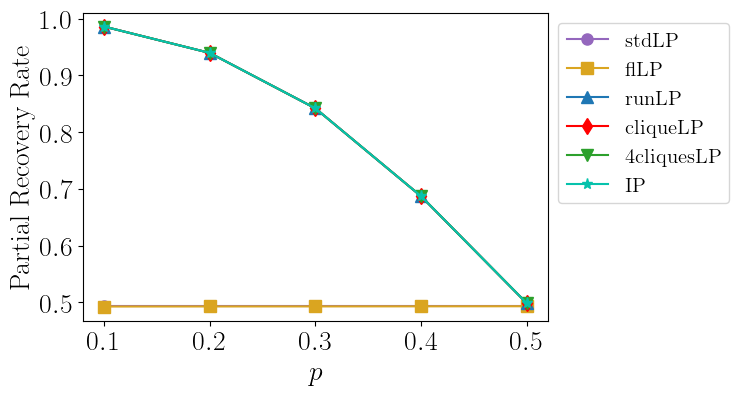

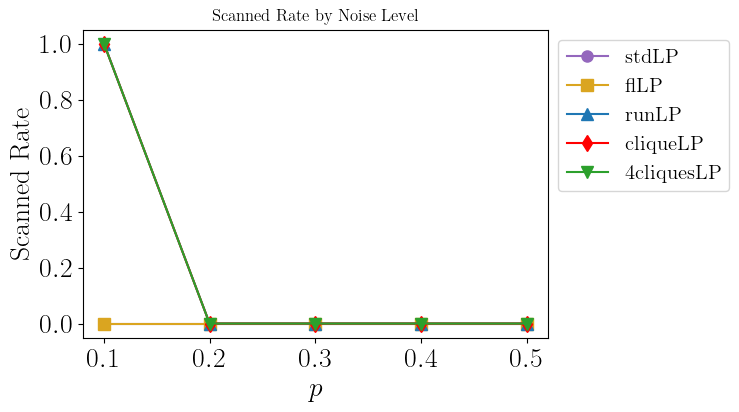

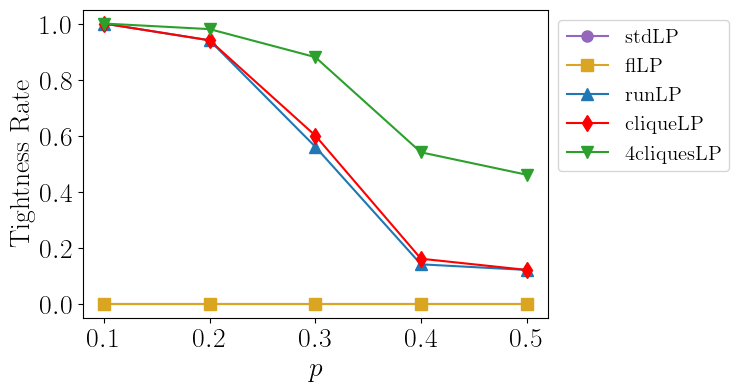

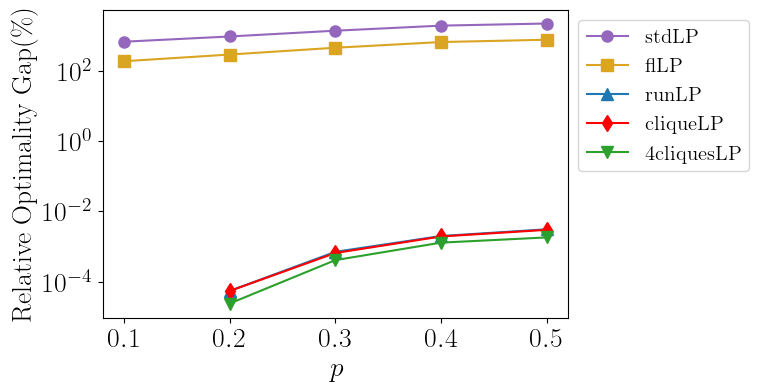

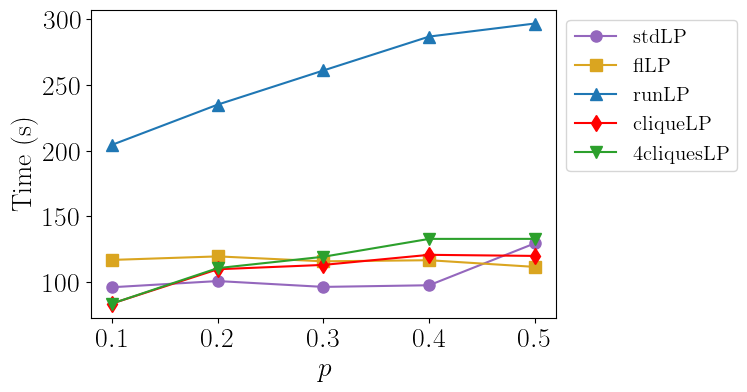

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
def compute_statistics(results):
    statistics = {}
    for noise_level, trials in results.items():
        stats = {
            'recovery_rate': {},
            'gap': {},
            'time': {},
            'scanned_rate': {},
            'tightness_rate': {}
        }

        # Initialize dictionaries for each LP and IP
        methods = ['LP_SL', 'LP_flower', 'LP_run', 'LP_clique', 'LP_4cliques', 'IP']
        for method in methods:
            stats['recovery_rate'][method] = []
            stats['scanned_rate'][method] = []
            stats['tightness_rate'][method] = []  # Initialize as a list to count binary results
            stats['gap'][method] = []
            stats['time'][method] = []

        for trial in trials:
            ip_obj_value = float(trial['IP']['objective_value'])

            for method in methods:
                if method in trial:
                    recovery_rate = float(trial[method]['recovery_rate'])
                    is_scanned = trial[method].get('is_scanned', False)
                    is_binary = trial[method].get('is_binary', False)

                    stats['recovery_rate'][method].append(recovery_rate)
                    stats['scanned_rate'][method].append(is_scanned)
                    if is_binary:
                        stats['tightness_rate'][method].append(1)  # Count as binary
                    else:
                        stats['tightness_rate'][method].append(0)  # Not binary

                    if 'time' in trial[method]:
                        time = float(trial[method]['time'])
                        stats['time'][method].append(time)

                    lp_obj_value = float(trial[method]['objective_value'])
                    gap = abs(ip_obj_value - lp_obj_value) / abs(ip_obj_value)
                    stats['gap'][method].append(gap*100)

        # Compute average values
        for method in methods:
            stats['recovery_rate'][method] = sum(stats['recovery_rate'][method]) / len(stats['recovery_rate'][method])
            stats['scanned_rate'][method] = sum(stats['scanned_rate'][method]) / len(stats['scanned_rate'][method])
            stats['tightness_rate'][method] = sum(stats['tightness_rate'][method]) / 50  # Average of binary count / 50
            stats['gap'][method] = sum(stats['gap'][method]) / len(stats['gap'][method])
            stats['time'][method] = sum(stats['time'][method]) / len(stats['time'][method]) if stats['time'][method] else 0

        statistics[noise_level] = stats
    return statistics

def plot_statistics(statistics):
    noise_levels = sorted(statistics.keys())
    methods = ['LP_SL', 'LP_flower', 'LP_run', 'LP_clique', 'LP_4cliques', 'IP']
    methods_label = ['stdLP', 'flLP', 'runLP', 'cliqueLP', '4cliquesLP', 'IP']
    styles = {
    'LP_SL': {'color': '#9467bd', 'marker': 'o'},
    'LP_flower': {'color': '#DAA520', 'marker': 's'},
    'LP_run': {'color': '#1f77b4', 'marker': '^'},
    'LP_clique': {'color': 'red', 'marker': 'd'},
    'LP_4cliques': {'color': '#2ca02c', 'marker': 'v'},
    'IP': {'color': '#06C2AC', 'marker': '*'}
    }

    # Plot Recovery Rates
    plt.figure(figsize=(6, 4))
    for i, method in enumerate(methods):
        recovery_rates = [statistics[nl]['recovery_rate'][method] for nl in noise_levels]
        print(recovery_rates)
        plt.plot(noise_levels, recovery_rates, marker=styles[method]['marker'],color=styles[method]['color'],markersize  = 8, label=methods_label[i])

    plt.xlabel(r'$p$',fontsize = 20)
    plt.xticks([0.1,0.2,0.3,0.4,0.5],fontsize = 20)
    plt.ylabel(r'Partial Recovery Rate',fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=15)
    plt.show()

    # Plot Scanned Rates
    plt.figure(figsize=(6, 4))
    for i, method in enumerate(methods[:-1]):
        scanned_rates = [statistics[nl]['scanned_rate'][method] for nl in noise_levels]
        plt.plot(noise_levels, scanned_rates, marker=styles[method]['marker'],color=styles[method]['color'], markersize  = 8,label=methods_label[i])
    plt.title('Scanned Rate by Noise Level')
    plt.xlabel(r'$p$',fontsize = 20)
    plt.xticks([0.1,0.2,0.3,0.4,0.5],fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylabel('Scanned Rate',fontsize = 20)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=15)
    plt.show()

    # Plot Tightness Rates
    plt.figure(figsize=(6, 4))
    for i, method in enumerate(methods[:-1]):
        scanned_rates = [statistics[nl]['tightness_rate'][method] for nl in noise_levels]
        plt.plot(noise_levels, scanned_rates, marker=styles[method]['marker'],color=styles[method]['color'], markersize  = 8, label=methods_label[i])

    plt.xlabel(r'$p$',fontsize = 20)
    plt.xticks([0.1,0.2,0.3,0.4,0.5],fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylabel(r'Tightness Rate',fontsize = 20)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=15)
    plt.show()

    # Plot Gaps for LPs only
    plt.figure(figsize=(6, 4))
    for i, method in enumerate(methods[:-1]):
        gaps = [statistics[nl]['gap'][method] for nl in noise_levels if statistics[nl]['gap'][method] > 1e-7]
        valid_noise_levels = [nl for nl in noise_levels if statistics[nl]['gap'][method] > 1e-7]
        plt.plot(valid_noise_levels, gaps, marker=styles[method]['marker'],color=styles[method]['color'], markersize  = 8, label=methods_label[i])

    plt.xlabel(r'$p$',fontsize = 20)
    plt.xticks([0.1,0.2,0.3,0.4,0.5],fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylabel(r'Relative Optimality Gap(\%)',fontsize = 20)
    plt.yscale('log')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=15)
    plt.show()

    plt.figure(figsize=(6, 4))
    for i, method in enumerate(methods[:-1]):  # Exclude IP for time plot
        times = [statistics[nl]['time'][method] for nl in noise_levels if statistics[nl]['time'].get(method)]
        valid_noise_levels = [nl for nl in noise_levels if statistics[nl]['time'].get(method)]
        plt.plot(valid_noise_levels, times, marker=styles[method]['marker'],color=styles[method]['color'], markersize  = 8,  label=methods_label[i])

    plt.xlabel(r'$p$',fontsize = 20)
    plt.xticks([0.1,0.2,0.3,0.4,0.5],fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylabel(r'Time (s)',fontsize = 20)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=15)
    plt.show()


statistics = compute_statistics(results)
plot_statistics(statistics)


**Plot grid search results**

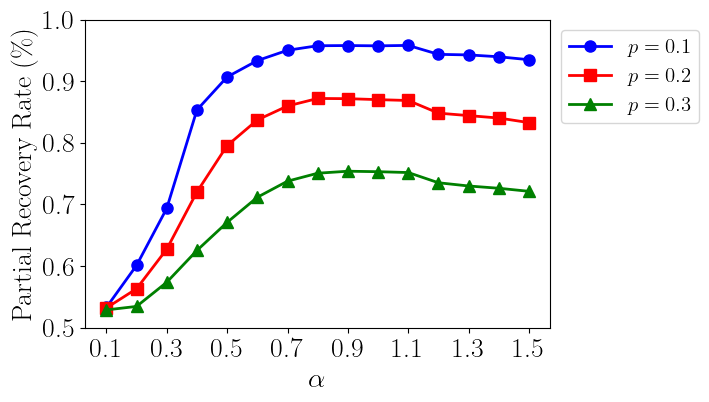

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# data = np.array(all_files_matrix)

data = np.array([
    [0.532512, 0.5317184, 0.528584],
    [0.600828, 0.5629312, 0.5342424],
    [0.693364, 0.6271528, 0.5734192],
    [0.8531728, 0.7200352, 0.6251088],
    [0.9067368, 0.7952784, 0.670668],
    [0.9333112, 0.8369344, 0.7114336],
    [0.950076, 0.859628, 0.7375584],
    [0.9574392, 0.8718384, 0.7505016],
    [0.9577552, 0.8715144, 0.7537304],
    [0.9572848, 0.86994, 0.7529656],
    [0.9579664, 0.86854, 0.7515808],
    [0.9434464, 0.848028, 0.7349992],
    [0.9425544, 0.8439936, 0.7297584],
    [0.9395432, 0.84008, 0.7260552],
    [0.9347464, 0.8326136, 0.7210928]
])

alphas = np.linspace(0.1, 1.5, 15)
p_values = [0.1, 0.2, 0.3]
markers = ['o', 's', '^']
colors = ['blue', 'red', 'green']

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Plotting the data
fig, ax = plt.subplots(figsize=(6, 4))
for i, (p, marker, color) in enumerate(zip(p_values, markers, colors)):
    ax.plot(alphas, data[:, i], label=rf'$p = {p:.1f}$', marker=marker, color=color, markersize=8, linewidth=2)

ax.set_xlabel(r'$\alpha$', fontsize=20)
ax.set_ylabel(r'Partial Recovery Rate (\%)', fontsize=20)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=15)
ax.set_xticks(np.linspace(0.1, 1.5, 8))
ax.set_xticklabels([f'{x:.1f}' for x in np.linspace(0.1, 1.5, 8)], fontsize=20)
ax.set_yticks(np.linspace(0.5, 1.0, 6))
ax.set_yticklabels([f'{y:.1f}' for y in np.linspace(0.5, 1.0, 6)], fontsize=20)

plt.show()
